In [1]:
import os
import glob
import pickle as pkl
import numpy as np
import pylab as pl
import seaborn as sns
import scipy.stats as spstats
import pandas as pd
import importlib

In [2]:
%matplotlib notebook

In [3]:
responsive_test='ROC'
responsive_thr=10. if responsive_test=='nstds' else 0.05
experiment='blobs'

traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
stats_dir = os.path.join(aggregate_dir, 'data-stats')

In [4]:
src_data_dir = os.path.join(aggregate_dir, 'data_stats', 'tmp_data')
dfns = glob.glob(os.path.join(src_data_dir, '*.pkl'))
dfns

['/n/coxfs01/julianarhee/aggregate-visual-areas/data_stats/tmp_data/neuraldata_traces001_corrected_ROC-thr-0.05_plushalf_noRFs.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data_stats/tmp_data/results.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data_stats/tmp_data/R.pkl']

In [5]:
src_datafile = os.path.join(src_data_dir, dfns[0])
with open(src_datafile, 'rb') as f:
    D = pkl.load(f, encoding='latin1')
D.keys()

dict_keys(['SDF', 'DATA', 'sdata', 'selective_df'])

In [38]:
DATA = D['DATA']
sdata = D['sdata']
SDF = D['SDF']
selective_df = D['selective_df']
DATA.head()

,datakey,config,trial,visual_area,cell,response,baseline
0,20190511_JC083_fov1,config047,1,V1,1,496.384479,486.518475
1,20190511_JC083_fov1,config021,2,V1,1,488.806161,482.074471
2,20190511_JC083_fov1,config031,3,V1,1,495.635289,488.475950
3,20190511_JC083_fov1,config032,4,V1,1,492.005017,488.053510
4,20190511_JC083_fov1,config014,5,V1,1,489.278178,496.740024


In [7]:
tmp_res = '/n/coxfs01/julianarhee/aggregate-visual-areas/data_stats/tmp_data/results.pkl'
with open(tmp_res, 'rb') as f:
    t = pkl.load(f, encoding='latin1')
mAUC = t['AUC']
estimates = t['estimates']

# Calculate AUC as performance

In [42]:
import scipy as sp
import itertools

def get_morph_levels(midp=53, levels=[-1, 0, 14, 27, 40, 53, 66, 79, 92, 106]):

    a_morphs = np.array(sorted([m for m in levels if m<midp and m!=-1]))[::-1]
    b_morphs = np.array(sorted([m for m in levels if m>midp and m!=-1]))

    d1 = dict((k, list(a_morphs).index(k)+1) for k in a_morphs)
    d2 = dict((k, list(b_morphs).index(k)+1) for k in b_morphs)
    morph_lut = d1.copy()
    morph_lut.update(d2)
    morph_lut.update({midp: 0, -1: -1})

    return morph_lut, a_morphs, b_morphs


In [43]:
def get_hits_and_fas(resp_stim, resp_bas, n_crit=50):
    
    # Get N conditions
    n_conditions = len(resp_stim) #curr_cfg_ixs)
 
    # Set criterion (range between min/max response)
    min_val = min(list(itertools.chain(*resp_stim))) #resp_stim.min()
    max_val = max(list(itertools.chain(*resp_stim))) #[r.max() for r in resp_stim]) #resp_stim.max() 
    crit_vals = np.linspace(min_val, max_val, n_crit)
   
    # For each crit level, calculate p > crit (out of N trials)   
    p_hits = np.array([[sum(rs > crit)/float(len(rs)) for crit in crit_vals] for rs in resp_stim])
    p_fas = np.array([[sum(rs > crit)/float(len(rs)) for crit in crit_vals] for rs in resp_bas])

    return p_hits, p_fas, crit_vals

def split_signal_distns(rdf, param='morphlevel', n_crit=50, include_ref=True, Eff=None,
                       class_a=0, class_b=106):
    '''
    param=='morphstep':
        Compare objectA vs B distributions at each morph step 
        Levels: 0=53/53, 1=40/66, 2=27/79, 3=4=14/92, 4=0/106
        Split trials into halves to calculate "chance" distN (evens/odds)
    param=='morph_ix' or 'morphlevel'
        Compare Ineffective distN against Effective distNs.
        Eff = prefered A or B, Ineff, the other object.
        Split trials into halfs for Ineff distN (evens/odds)
        
    '''
    Ineff=class_b if Eff==class_a else class_a
    if param=='morphstep':
        A_obj = 'A' if Ineff==class_a else 'B'
        B_obj = 'B' if Eff==class_b else 'A'
        resp_A = [g['response'].values for c, g in rdf[rdf.object==A_obj].groupby(['morphstep', 'size'])]
        resp_B = [g['response'].values for c, g in rdf[rdf.object==B_obj].groupby(['morphstep', 'size'])]

        resp_cfgs1 = [c for c, g in rdf[rdf.object==A_obj].groupby(['morphstep', 'size'])]
        resp_cfgs2 = [c for c, g in rdf[rdf.object==B_obj].groupby(['morphstep', 'size'])]
        assert resp_cfgs1==resp_cfgs2, \
            "ERR: morph levels and sizes don't match for object A and B"
        resp_counts = [g.shape[0] for c, g in rdf[rdf.object==A_obj].groupby(['morphstep', 'size'])]

        if include_ref:
            resp_A_REF = [g['response'].values[0::2] for c, g \
                             in rdf[rdf.object=='M'].groupby(['morphstep', 'size'])]
            resp_B_REF = [g['response'].values[1::2] for c, g \
                             in rdf[rdf.object=='M'].groupby(['morphstep', 'size'])]
            resp_cfgs_REF = [c for c, g in \
                             rdf[rdf.object=='M'].groupby(['morphstep', 'size'])]
            resp_counts_REF = [g.shape[0] for c, g in \
                             rdf[rdf.object=='M'].groupby(['morphstep', 'size'])]
            # Add to resp
            resp_cfgs1.extend(resp_cfgs_REF)
            resp_A.extend(resp_A_REF)
            resp_B.extend(resp_B_REF)
            resp_counts.extend(resp_counts_REF)
    else:
        # Responses to Everythign that's not "Ineffective" stimuli
        resp_B = [g['response'].values for c, g in rdf[rdf[param]!=Ineff].groupby([param, 'size'])]
        resp_cfgs1 = [c for c, g in rdf[rdf[param]!=Ineff].groupby([param, 'size'])]
        resp_counts = [g.shape[0] for c, g in rdf[rdf[param]!=Ineff].groupby([param, 'size'])]

        # Responses to "Ineffective" (baseline distN)
        if include_ref:
            # Split responses to Eff in half
            resp_A = [g['response'].values[1::2] for c, g in rdf[rdf[param]==Ineff].groupby([param, 'size'])]
            resp_A_REF = [g['response'].values[0::2] for c, g in rdf[rdf[param]==Ineff].groupby([param, 'size'])]
            resp_cfgs_REF = [c for c, g in rdf[rdf[param]==Ineff].groupby([param, 'size'])]
            resp_counts_REF = [g.shape[0] for c, g in rdf[rdf[param]==Ineff].groupby([param, 'size'])]

            # Add to list of comparison DistNs
            resp_B.extend(resp_A_REF)
            resp_cfgs1.extend(resp_cfgs_REF)
            resp_counts.extend(resp_counts_REF)
        else:
            resp_A = [g['response'].values for c, g in rdf[rdf[param]==Ineff].groupby([param, 'size'])]

    p_hits, p_fas, crit_vals = get_hits_and_fas(resp_B, resp_A, n_crit=n_crit)
    
    return p_hits, p_fas, resp_cfgs1, resp_counts
    
    
def calculate_auc(p_hits, p_fas, resp_cfgs1, reverse_eff=False, Eff=None):
    if p_fas.shape[0] < p_hits.shape[0]:
        altconds = list(np.unique([c[1] for c in resp_cfgs1]))
        true_auc = [-np.trapz(p_hits[mi, :], x=p_fas[altconds.index(sz), :]) \
                            for mi, (mp, sz) in enumerate(resp_cfgs1)]
    else:
        true_auc = [-np.trapz(p_hits[ci, :], x=p_fas[ci, :]) for ci in np.arange(0, len(resp_cfgs1))]
        
    aucs = pd.DataFrame({'AUC': true_auc, 
                          param: [r[0] for r in resp_cfgs1], 
                         'size': [r[1] for r in resp_cfgs1]}) 
    if reverse_eff and Eff==0:
        # flip
        for sz, a in aucs.groupby(['size']):
            aucs.loc[a.index, 'AUC'] = a['AUC'].values[::-1]
            
        #aucs['AUC'] = aucs['AUC'].values[::-1]
        
    return aucs

def get_auc_AB(rdf, param='morphlevel', n_crit=50, include_ref=True, reverse_eff=False,
                  class_a=0, class_b=106, return_probs=False):
    '''
    Calculate AUCs for A vs. B at each size. 
    Note:  rdf must contain columns 'morphstep' and 'size' (morphstep LUT from: get_morph_levels())

    include_end: include morphlevel=0 (or morph_ixx) by splitting into half.
    Compare p_hit (morph=0) to p_fa (morph=106), calculate AUC.
    '''
    # Get Eff/Ineff
    means = rdf[rdf.morphlevel.isin([class_a, class_b])].groupby(['object']).mean()
    Eff = class_a if means['response']['A'] > means['response']['B'] else class_b

    p_hits, p_fas, resp_cfgs1, counts = split_signal_distns(rdf, param=param, n_crit=n_crit, 
                                                        include_ref=include_ref, Eff=Eff)
        
    aucs =  calculate_auc(p_hits, p_fas, resp_cfgs1, reverse_eff=reverse_eff, Eff=Eff)
    aucs['n_trials'] = counts
    aucs['Eff'] = Eff
    
    if return_probs:
        return aucs, p_hits, p_fas, resp_cfgs1
    else:
        return aucs

def plot_auc_for_cell(rdf, param='morphlevel', class_a=0, class_b=106, n_crit=50, include_ref=True, cmap='RdBu'):
    
    means = rdf[rdf.morphlevel.isin([class_a, class_b])].groupby(['object']).mean()
    print(means)
    # Get Eff/Ineff
    Eff = class_a if means['response']['A'] > means['response']['B'] else class_b

    # Calculate p_hits/p_fas for plot
    p_hits, p_fas, resp_cfgs1 = split_signal_distns(rdf, param=param, n_crit=n_crit, 
                                                    include_ref=include_ref, Eff=Eff)
    print(p_hits.shape, p_fas.shape, len(resp_cfgs1))
    aucs = calculate_auc(p_hits, p_fas, resp_cfgs1, reverse_eff=False, Eff=Eff)

    # Plot----
    mdiffs = sorted(aucs[param].unique())
    mdiff_colors = sns.color_palette(cmap, n_colors=len(mdiffs))
    colors = dict((k, v) for k, v in zip(mdiffs, mdiff_colors))

    fig, axn = pl.subplots(1, len(sizes), figsize=(8,3))    
    for mi, (mp, sz) in enumerate(resp_cfgs1):
        si = sizes.index(sz)
        ax=axn[si]
        if param=='morphstep':
            ax.plot(p_fas[mi, :], p_hits[mi, :], color=colors[mp], label=mp)
        else:
            ax.plot(p_fas[si, :], p_hits[mi, :], color=colors[mp], label=mp)
        ax.set_title(sz)
        ax.set_aspect('equal')
        ax.plot([0, 1], [0, 1], linestyle=':', color='k', lw=1)
    ax.legend(bbox_to_anchor=(1, 1.2), loc='lower right', title=param, ncol=5)
    pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, hspace=0.5, wspace=0.5, top=0.7)
    return fig

In [44]:
def data_matrix_from_auc(auc_, param='morphlevel', normalize=False):
    auc_['n_chooseB'] = auc_['AUC'] * auc_['n_trials']
    auc_['n_chooseB'] = np.ceil(auc_['n_chooseB']) #.astype(int)
    
    if normalize:
        maxv = float(auc_[param].max())
        auc_[param] = auc_[param]/maxv
    
    data = auc_[[param, 'n_chooseB', 'n_trials']].values

    return data

In [564]:
param='morphstep'
midp=53

a_=[]
DATA['cell'] = DATA['cell'].astype(int)
for (va, dk), nd in DATA.groupby(['visual_area', 'datakey']):
    
    # get selective cells
    seldf = selective_df[(selective_df.visual_area==va) & (selective_df.datakey==dk)].copy()
    sel_cells = seldf['cell'].unique().astype(int)
    
    # add stimulus info
    sdf = SDF[dk].copy()
    morphlevels = sdf['morphlevel'].unique()
    sizes = list(sdf['size'].unique())
    if midp not in morphlevels:
        print("... (%s, %s) Unknown midpoint in morphs: %s" % (dk, va, str(morphlevels)))
        continue
    nd['size'] = [sdf['size'][c] for c in nd['config']]
    nd['morphlevel'] = [sdf['morphlevel'][c] for c in nd['config']]
    ndf = nd[(nd['cell'].isin(sel_cells)) & (nd['morphlevel']!=-1)].copy()
    
    morph_lut, a_morphs, b_morphs = get_morph_levels(levels=morphlevels, midp=midp)
    # update neuraldata
    ndf['morphstep'] = [morph_lut[m] for m in ndf['morphlevel']]
    ndf['morph_ix'] = [m/106. for m in ndf['morphlevel']]
    ndf['object'] = None
    ndf.loc[ndf.morphlevel.isin(a_morphs), 'object'] = 'A'
    ndf.loc[ndf.morphlevel.isin(b_morphs), 'object'] = 'B'
    ndf.loc[ndf.morphlevel==midp, 'object'] = 'M'
    
    # calculate AUCs
#     def get_auc_AB(rdf, param='morphlevel', n_crit=50, include_ref=True, reverse_eff=False,
#                   class_a=0, class_b=106):

    reverse_eff = param!='morphstep'
    AUC0 = ndf.groupby('cell').apply(get_auc_AB, reverse_eff=reverse_eff, param=param)
    AUC0['visual_area'] = va
    AUC0['datakey'] = dk
    a_.append(AUC0)
    #neuromorphs = AUC.groupby(['cell', 'size']).apply(fit_neurometric).reset_index().drop('level_2', axis=1)

mAUC = pd.concat(a_).reset_index() #.drop('level_1', axis=1)
mAUC.head()

,cell,level_1,AUC,morphstep,size,n_trials,Eff,visual_area,datakey
0,76,0,0.508333,1.0,10.0,30.0,106.0,Li,20190422_JC076_fov1
1,76,1,0.525556,1.0,20.0,30.0,106.0,Li,20190422_JC076_fov1
2,76,2,0.351667,1.0,30.0,30.0,106.0,Li,20190422_JC076_fov1
3,76,3,0.526667,1.0,40.0,30.0,106.0,Li,20190422_JC076_fov1
4,76,4,0.600556,1.0,50.0,30.0,106.0,Li,20190422_JC076_fov1


#### test 1 animal

In [59]:
va='V1'
dk = '20190616_JC097_fov1'
midp=53

In [60]:

nd = DATA[(DATA.visual_area==va) & (DATA.datakey==dk)].copy()
# get selective cells
seldf = selective_df[(selective_df.visual_area==va) & (selective_df.datakey==dk)].copy()
sel_cells = seldf['cell'].unique().astype(int)

# add stimulus info
sdf = SDF[dk].copy()
morphlevels = sdf['morphlevel'].unique()
sizes = list(sdf['size'].unique())
if midp not in morphlevels:
    print("... (%s, %s) Unknown midpoint in morphs: %s" % (dk, va, str(morphlevels)))
nd['size'] = [sdf['size'][c] for c in nd['config']]
nd['morphlevel'] = [sdf['morphlevel'][c] for c in nd['config']]
ndf = nd[(nd['cell'].isin(sel_cells)) & (nd['morphlevel']!=-1)].copy()

morph_lut, a_morphs, b_morphs = get_morph_levels(levels=morphlevels, midp=midp)
# update neuraldata
ndf['morphstep'] = [morph_lut[m] for m in ndf['morphlevel']]
ndf['morph_ix'] = [m/106. for m in ndf['morphlevel']]
ndf['object'] = None
ndf.loc[ndf.morphlevel.isin(a_morphs), 'object'] = 'A'
ndf.loc[ndf.morphlevel.isin(b_morphs), 'object'] = 'B'
ndf.loc[ndf.morphlevel==midp, 'object'] = 'M'


In [178]:
class_a=0
class_b=106
include_ref=True
n_crit=20

rid=217 #90 #217
rdf = ndf[ndf['cell']==rid].copy()

means = rdf[rdf.morphlevel.isin([class_a, class_b])].groupby(['object']).mean()
Eff = class_a if means['response']['A'] > means['response']['B'] else class_b


param = 'morphlevel'
reverse_eff = param!='morphstep'
aucs, p_hits, p_fas, resp_cfgs1 = get_auc_AB(rdf, param=param, n_crit=50, reverse_eff=reverse_eff,
                  class_a=0, class_b=106, return_probs=True)

In [179]:
aucs[aucs['size']==50]

,AUC,morphlevel,size,n_trials,Eff
4,0.668889,0,50.0,30,0
9,0.574444,14,50.0,30,0
14,0.625556,27,50.0,30,0
19,0.587778,40,50.0,30,0
24,0.713333,53,50.0,30,0
29,0.564444,66,50.0,30,0
34,0.512222,79,50.0,30,0
39,0.691111,92,50.0,30,0
44,0.540000,106,50.0,30,0


<IPython.core.display.Javascript object>


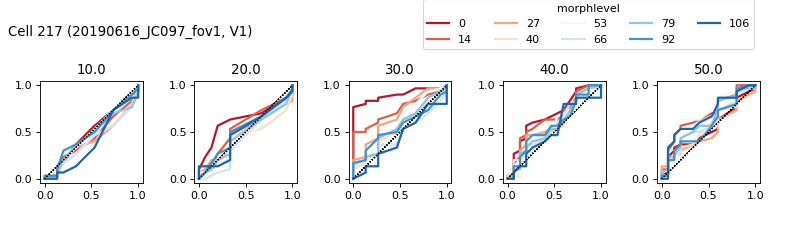

Text(0.01, 0.85, 'Cell 217 (20190616_JC097_fov1, V1)')

In [180]:
cmap='plasma' if param=='morphstep' else 'RdBu'
lw=2
# Plot----
mdiffs = sorted(aucs[param].unique())
mdiff_colors = sns.color_palette(cmap, n_colors=len(mdiffs))
colors = dict((k, v) for k, v in zip(mdiffs, mdiff_colors))

fig, axn = pl.subplots(1, len(sizes), figsize=(10,3))    
for mi, (mp, sz) in enumerate(resp_cfgs1):
    si = sizes.index(sz)
    ax=axn[si]
    if param=='morphstep':
        ax.plot(p_fas[mi, :], p_hits[mi, :], color=colors[mp], label=mp, lw=lw)
    else:
        ax.plot(p_fas[si, :], p_hits[mi, :], color=colors[mp], label=mp, lw=lw)
    ax.set_title(sz)
    ax.set_aspect('equal')
    ax.plot([0, 1], [0, 1], linestyle=':', color='k', lw=1)
ax.legend(bbox_to_anchor=(1, 1.25), loc='lower right', title=param, ncol=5)
pl.subplots_adjust(left=0.05, right=0.95, bottom=0.2, hspace=0.5, wspace=0.5, top=0.7)
fig.text(0.01, 0.85, 'Cell %i (%s, %s)' % (rid, dk, va), fontsize=12)


In [181]:
va, dk

('V1', '20190616_JC097_fov1')

In [182]:
pass_estimates[(pass_estimates.visual_area==va) & (pass_estimates.datakey==dk)].sort_values(by='width')

,threshold,width,lambda,gamma,eta,slope,thr,cell,visual_area,datakey
612,3.537107,1.937066,5.443768e-09,0.5,3.880869e-09,0.338761,3.537107,238,V1,20190616_JC097_fov1
629,3.962093,1.960698,1.832562e-05,0.5,3.768605e-05,0.334665,3.962120,386,V1,20190616_JC097_fov1
614,3.965672,1.969733,4.871722e-09,0.5,6.791217e-09,0.333142,3.965672,253,V1,20190616_JC097_fov1
610,3.755816,1.976677,1.270754e-08,0.5,3.632724e-08,0.331972,3.755816,224,V1,20190616_JC097_fov1
605,3.851016,1.992639,1.912973e-05,0.5,2.328139e-09,0.329300,3.851045,210,V1,20190616_JC097_fov1
591,3.818806,2.259239,1.020830e-08,0.5,3.958234e-10,0.290452,3.818806,153,V1,20190616_JC097_fov1
638,3.928171,2.486890,2.958800e-06,0.5,4.216728e-10,0.263863,3.928177,425,V1,20190616_JC097_fov1
611,3.474573,2.577888,3.582001e-10,0.5,4.856031e-06,0.254550,3.474573,232,V1,20190616_JC097_fov1
637,3.926660,2.695036,1.065923e-09,0.5,7.591867e-11,0.243485,3.926660,410,V1,20190616_JC097_fov1
604,3.804542,2.725935,7.850298e-11,0.5,1.425629e-07,0.240725,3.804542,208,V1,20190616_JC097_fov1


In [183]:
auc_ = aucs[aucs['size']==50].copy()
auc_['n_chooseB'] = auc_['AUC']*auc_['n_trials']
auc_
data_ = data_matrix_from_auc(auc_, param=param,normalize=True)
data_

array([[ 0.        , 21.        , 30.        ],
       [ 0.13207547, 18.        , 30.        ],
       [ 0.25471698, 19.        , 30.        ],
       [ 0.37735849, 18.        , 30.        ],
       [ 0.5       , 22.        , 30.        ],
       [ 0.62264151, 17.        , 30.        ],
       [ 0.74528302, 16.        , 30.        ],
       [ 0.86792453, 21.        , 30.        ],
       [ 1.        , 17.        , 30.        ]])

In [184]:
import psignifit as ps


In [185]:
importlib.reload(ps)
importlib.reload(ps.psigniplot)


<module 'psignifit.psigniplot' from '/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py'>

In [186]:
opts = dict()
opts['sigmoidname'] = 'weibull'
opts['expType'] = '2AFC' #'2AFC'
opts['threshPC'] = 0.5
at_pc = 0.75 if opts['expType']=='2AFC' else 0.5


<IPython.core.display.Javascript object>


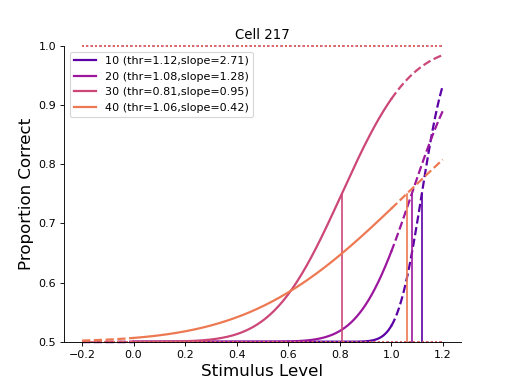

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndar

In [188]:
cols = sns.color_palette('plasma', n_colors=5)

size_colors = dict((k, v) for k, v in zip(sizes, cols))
size_res={}


fig, ax = pl.subplots()
for curr_sz in sizes:
    auc_ = aucs[aucs['size']==curr_sz].copy()
    auc_['n_chooseB'] = auc_['AUC']*auc_['n_trials']
    data_ = data_matrix_from_auc(auc_, param=param,normalize=True)
    res_ = ps.psignifit(data_, opts)
    try:
        thr = ps.getThreshold(res_, at_pc)[0] # Value at which function reaches at_pc correct
        slp = ps.getSlope(res_, ps.getThreshold(res_, at_pc)[0]) # Slope at given stimulus level
    except Exception as e:
        continue
#     print(curr_sz, thr, slp)
    info_str = '%i (thr=%.2f,slope=%.2f)' % (curr_sz, thr, slp)
    ax = ps.psigniplot.plotPsych(res_, axisHandle=ax, plotData=False, 
                                 lineColor=size_colors[curr_sz], label=info_str)
    size_res[curr_sz] = res_
    
ax.set_title('Cell %i' % (rid))
ax.legend()

##### baseline is baseline

In [497]:
# ---------------

def get_auc(rdf, n_crit=50):
    #cfgs = sorted(rdf['config'].unique())
    #rid = float(rdf['cell'].unique())
    resp_stim = [g['response'].values for c, g in  rdf.groupby(['config'])]
    resp_bas = [g['baseline'].values for c, g in  rdf.groupby(['config'])]
    cfgs = [c for c, g in  rdf.groupby(['config'])]
    n_conditions = len(resp_stim)
    p_hits, p_fas, crit_vals = get_hits_and_fas(resp_stim, resp_bas, n_crit=n_crit)

    true_auc = [-np.trapz(p_hits[ci, :], x=p_fas[ci, :]) for ci in np.arange(0, n_conditions)]
    aucs = pd.DataFrame({'AUC': true_auc, 'config': cfgs})
    
    return aucs, p_hits, p_fas

In [498]:
aucs,p_hits, p_fas= get_auc(rdf)
aucs['size'] = [sdf['size'][c] for c in aucs['config']]
aucs['morphlevel'] = [sdf['morphlevel'][c] for c in aucs['config']]
aucs['n_trials'] = 30

In [499]:
cmap='RdBu'
# Plot----
mdiffs = sorted(aucs[param].unique())
mdiff_colors = sns.color_palette(cmap, n_colors=len(mdiffs))
colors = dict((k, v) for k, v in zip(mdiffs, mdiff_colors))

fig, axn = pl.subplots(1, len(sizes), figsize=(8,3))    
for mi, (mp, sz) in enumerate(resp_cfgs1):
    si = sizes.index(sz)
    ax=axn[si]
    if param=='morphstep':
        ax.plot(p_fas[mi, :], p_hits[mi, :], color=colors[mp], label=mp)
    else:
        ax.plot(p_fas[si, :], p_hits[mi, :], color=colors[mp], label=mp)
    ax.set_title(sz)
    ax.set_aspect('equal')
    ax.plot([0, 1], [0, 1], linestyle=':', color='k', lw=1)
ax.legend(bbox_to_anchor=(1, 1.2), loc='lower right', title=param, ncol=5)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, hspace=0.5, wspace=0.5, top=0.7)


KeyError: 'morphstep'

##### NULL distN is midmorph

In [467]:

# Responses to Everythign that's not "Ineffective" stimuli
resp_B = [g['response'].values for c, g in rdf[rdf[param]!=midp].groupby([param, 'size'])]
resp_cfgs1 = [c for c, g in rdf[rdf[param]!=midp].groupby([param, 'size'])]
resp_counts = [g.shape[0] for c, g in rdf[rdf[param]!=midp].groupby([param, 'size'])]

# Responses to "Ineffective" (baseline distN)
# if include_ref:
#     # Split responses to Eff in half
#     resp_A = [g['response'].values[1::2] for c, g in rdf[rdf[param]==Ineff].groupby([param, 'size'])]
#     resp_A_REF = [g['response'].values[0::2] for c, g in rdf[rdf[param]==Ineff].groupby([param, 'size'])]
#     resp_cfgs_REF = [c for c, g in rdf[rdf[param]==Ineff].groupby([param, 'size'])]
#     resp_counts_REF = [g.shape[0] for c, g in rdf[rdf[param]==Ineff].groupby([param, 'size'])]

#     # Add to list of comparison DistNs
#     resp_B.extend(resp_A_REF)
#     resp_cfgs1.extend(resp_cfgs_REF)
#     resp_counts.extend(resp_counts_REF)
# else:
resp_A = [g['response'].values for c, g in rdf[rdf[param]==midp].groupby([param, 'size'])]

p_hits, p_fas, crit_vals = get_hits_and_fas(resp_B, resp_A, n_crit=n_crit)



In [468]:
p_hits.shape, p_fas.shape


((40, 20), (5, 20))

In [473]:
auc_m = calculate_auc(p_hits, p_fas, resp_cfgs1, reverse_eff=True, Eff=Eff)
auc_m['n_trials'] = 30
auc_m['n_chooseB'] = auc_m['AUC']*auc_m['n_trials']
auc_m

,AUC,morphlevel,size,n_trials,n_chooseB
0,0.513889,0,10.0,30,15.416667
1,0.533889,0,20.0,30,16.016667
2,0.388333,0,30.0,30,11.650000
3,0.465000,0,40.0,30,13.950000
4,0.368333,0,50.0,30,11.050000
5,0.550000,14,10.0,30,16.500000
6,0.568889,14,20.0,30,17.066667
7,0.512778,14,30.0,30,15.383333
8,0.534444,14,40.0,30,16.033333
9,0.380556,14,50.0,30,11.416667


<IPython.core.display.Javascript object>


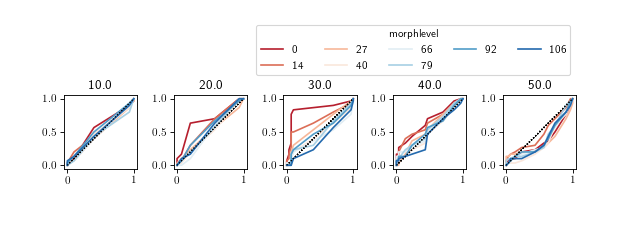

In [474]:
cmap='RdBu'
# Plot----
mdiffs = sorted(auc_m[param].unique())
mdiff_colors = sns.color_palette(cmap, n_colors=len(mdiffs))
colors = dict((k, v) for k, v in zip(mdiffs, mdiff_colors))
curr_sizes = [s for s in sizes if s in auc_m['size'].unique()]

fig, axn = pl.subplots(1, len(sizes), figsize=(8,3))    
for mi, (mp, sz) in enumerate(resp_cfgs1):
    si = curr_sizes.index(sz)
    ax=axn[si]
    if param=='morphstep':
        ax.plot(p_fas[mi, :], p_hits[mi, :], color=colors[mp], label=mp)
    else:
        ax.plot(p_fas[si, :], p_hits[mi, :], color=colors[mp], label=mp)
    ax.set_title(sz)
    ax.set_aspect('equal')
    ax.plot([0, 1], [0, 1], linestyle=':', color='k', lw=1)
ax.legend(bbox_to_anchor=(1, 1.2), loc='lower right', title=param, ncol=5)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, hspace=0.5, wspace=0.5, top=0.7)


In [476]:
auc_ = auc_m[auc_m['size']==30].copy()
#auc_['AUC'] = auc_['AUC'].values[::-1]
auc_['n_chooseB'] = auc_['AUC']*auc_['n_trials']
data_m = data_matrix_from_auc(auc_)
auc_

,AUC,morphlevel,size,n_trials,n_chooseB
2,0.388333,0.000000,30.0,30,12.0
7,0.512778,0.132075,30.0,30,16.0
12,0.477222,0.254717,30.0,30,15.0
17,0.430556,0.377358,30.0,30,13.0
22,0.483333,0.622642,30.0,30,15.0
27,0.592778,0.745283,30.0,30,18.0
32,0.674444,0.867925,30.0,30,21.0
37,0.841667,1.000000,30.0,30,26.0


In [477]:
opts = dict()
opts['sigmoidname'] = 'weibull'
opts['expType'] = 'YesNo' #'2AFC'
opts['threshPC'] = 0.5
at_pc = 0.75 if opts['expType']=='2AFC' else 0.5

res_m = ps.psignifit(data_m, opts)

(array([], dtype=int64),)


/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


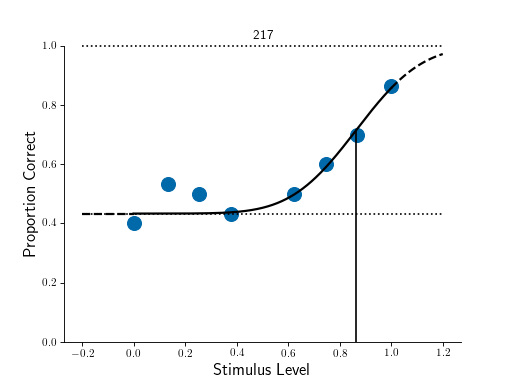

Text(0.5, 1.0, '217')

In [478]:
fig, ax = pl.subplots()
ax = ps.psigniplot.plotPsych(res_m, axisHandle=ax)
ax.set_title(rid)

In [461]:
auc_ = auc[auc['size']==30].copy()
auc_['AUC'] = auc_['AUC'].values[::-1]
auc_['n_chooseB'] = auc_['AUC']*auc_['n_trials']
data = data_matrix_from_auc(auc_)


In [465]:
opts = dict()
opts['sigmoidname'] = 'weibull'
opts['expType'] = '2AFC' #'2AFC'
opts['threshPC'] = 0.5
at_pc = 0.75 if opts['expType']=='2AFC' else 0.5

res = ps.psignifit(data, opts)

(array([], dtype=int64),)


/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


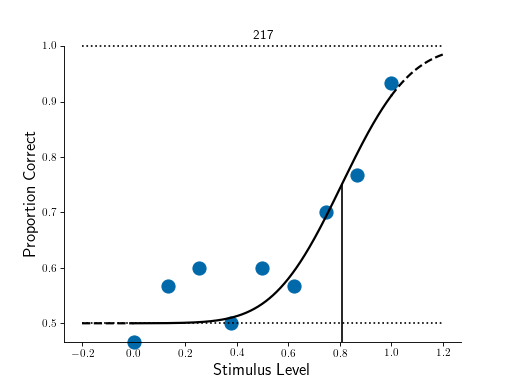

Text(0.5, 1.0, '217')

In [466]:
fig, ax = pl.subplots()
ax = ps.psigniplot.plotPsych(res, axisHandle=ax)
ax.set_title(rid)

# Test fit

In [142]:
import psignifit as ps

In [581]:
va='Li'
dk = '20190602_JC091_fov1'

#aucs = mAUC[(mAUC.visual_area==va) & (mAUC.datakey==dk)].copy()
aucs = mAUC[(mAUC.visual_area==va)].copy()

aucs.head()
print(aucs.shape)

(5850, 9)


In [582]:
max_auc=0.7
pass_cells = aucs[aucs['AUC']>=max_auc]['cell'].unique()
print("%i of %i cells pass crit (%.2f)" % (len(pass_cells), len(aucs['cell'].unique()), max_auc))
pass_auc = aucs[aucs['cell'].isin(pass_cells)].copy()

92 of 180 cells pass crit (0.70)


In [583]:
#Best config (size) for each cell
max_auc_ixs = pass_auc.groupby(['cell'])['AUC'].transform(max) == pass_auc['AUC']
best_sz_per_cell = [(r, c) for (r, c), g in pass_auc[max_auc_ixs].groupby(['cell', 'size'])]
assert len(pass_cells)==len(best_sz_per_cell)
best_auc = pd.concat([g for (r,c), g in pass_auc.groupby(['cell', 'size']) if (r, c) in best_sz_per_cell])
best_auc.head()


,cell,level_1,AUC,morphstep,size,n_trials,Eff,visual_area,datakey
5151,8,1,0.468421,1.0,20.0,19.0,0.0,Li,20190617_JC099_fov1
5156,8,6,0.759003,2.0,20.0,19.0,0.0,Li,20190617_JC099_fov1
5161,8,11,0.478947,3.0,20.0,19.0,0.0,Li,20190617_JC099_fov1
5166,8,16,0.543750,4.0,20.0,20.0,0.0,Li,20190617_JC099_fov1
5171,8,21,0.540000,0.0,20.0,20.0,0.0,Li,20190617_JC099_fov1


In [586]:
importlib.reload(ps)

<module 'psignifit' from '/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/__init__.py'>

In [587]:
opts = dict()
opts['sigmoidname'] = 'weibull'
opts['expType'] = '2AFC' #'2AFC'
opts['threshPC'] = 0.5
at_pc = 0.75 if opts['expType']=='2AFC' else 0.5

In [588]:
results={}
d_=[]
for rid, auc_r in best_auc.groupby(['cell']):
    data = data_matrix_from_auc(auc_r, param=param)
    res = ps.psignifit(data, opts)
    results[rid] = res
    df_ = pd.DataFrame(res['Fit'], index=param_names, columns=[rid]).T
    try:
        thr = ps.getThreshold(res, 0.75)[0] # Value at which function reaches at_pc correct
        slp = ps.getSlope(res, ps.getThreshold(res, 0.75)[0]) # Slope at given stimulus level
    except Exception as e:
        thr=None
        slp=None
    df_['slope'] = slp
    df_['thr'] = thr
    d_.append(df_)


(array([], dtype=int64),)


/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

In [590]:
estimates = pd.concat(d_, axis=0)
print(estimates.shape)
estimates.head()

(92, 7)


,threshold,width,lambda,gamma,eta,slope,thr
8,4.540502,1.958650,1.326971e-10,0.5,2.497581e-05,0.335027,4.540502
10,4.108270,4.487008,8.432182e-11,0.5,1.828973e-08,0.146245,4.108270
13,4.495817,6.404034,3.946905e-06,0.5,1.279978e-11,0.102466,4.495836
15,4.809047,1.899614,4.208564e-09,0.5,1.052172e-09,0.345439,4.809047
16,3.950602,6.919995,4.368838e-09,0.5,3.905445e-08,0.094827,3.950602


In [591]:
max_x = float(aucs[param].max())

pass_estimates = estimates[(estimates['threshold']>=0) & (estimates['threshold']<=max_x)].dropna()

fit_cells = pass_estimates.index.tolist()
print('%i cells with valid fits' % len(fit_cells))

27 cells with valid fits


In [691]:
max_auc=0.7
opts = dict()
opts['sigmoidname'] = 'weibull'
opts['expType'] = '2AFC' #'2AFC'
opts['threshPC'] = 0.5
at_pc = 0.75 if opts['expType']=='2AFC' else 0.5

#e_=[]
#R = dict((k, {v: None}) for (k, v), g in mAUC.groupby(['visual_area', 'datakey']))

for (va, dk), aucs in mAUC.groupby(['visual_area', 'datakey']):

    #aucs = mAUC[(mAUC.visual_area==va)].copy()
    if dk in R[va].keys() and isinstance(R[va][dk], dict): #@ is not None:
        continue
        
    # Cells that pass performance criterion
    pass_cells = aucs[aucs['AUC']>=max_auc]['cell'].unique()
    print("%i of %i cells pass crit (%.2f)" % (len(pass_cells), len(aucs['cell'].unique()), max_auc))
    pass_auc = aucs[aucs['cell'].isin(pass_cells)].copy()

    # Best config (size) for each cell
    max_auc_ixs = pass_auc.groupby(['cell'])['AUC'].transform(max) == pass_auc['AUC']
    ix = pass_auc[max_auc_ixs]['cell'].drop_duplicates().index.tolist()
    best_sz_per_cell = [(r, c) for (r, c), g in pass_auc.loc[ix].groupby(['cell', 'size'])]
    assert len(pass_cells)==len(best_sz_per_cell)
    if len(best_sz_per_cell)==0:
        print("****[%s, %s] no cells." % (va, dk))
        continue
    best_auc = pd.concat([g for (r,c), g in pass_auc.groupby(['cell', 'size']) if (r, c) in best_sz_per_cell])

    results={}
    d_=[]
    for rid, auc_r in best_auc.groupby(['cell']):
        data = data_matrix_from_auc(auc_r, param=param)
        res = ps.psignifit(data, opts)
        results[rid] = res
        df_ = pd.DataFrame(res['Fit'], index=param_names, columns=[rid]).T
        try:
            thr = ps.getThreshold(res, 0.75)[0] # Value at which function reaches at_pc correct
            slp = ps.getSlope(res, ps.getThreshold(res, 0.75)[0]) # Slope at given stimulus level
        except Exception as e:
            thr=None
            slp=None
        df_['slope'] = slp
        df_['thr'] = thr
        d_.append(df_)
    est = pd.concat(d_, axis=0)
    est['cell'] = est.index.tolist()
    est['visual_area'] = va
    est['datakey'] = dk
    e_.append(est)
    
    R[va][dk] = results
    

0 of 6 cells pass crit (0.70)
****[V1, 20190517_JC083_fov1] no cells.
48 of 92 cells pass crit (0.70)
(array([], dtype=int64),)


/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


In [692]:
for k, v in R.items():
    for kk, vv in v.items():
        if vv is None:
            print(k, kk, vv)

In [693]:
estimates = pd.concat(e_).reset_index(drop=True)
estimates.head()

,threshold,width,lambda,gamma,eta,slope,thr,cell,visual_area,datakey
0,4.532189,1.966370,1.557351e-10,0.5,2.685067e-09,0.333712,4.532189,186,Li,20190422_JC076_fov1
1,3.892998,1.914792,1.401999e-08,0.5,1.602869e-07,0.342701,3.892998,261,Li,20190422_JC076_fov1
2,4.509790,5.885670,5.069362e-05,0.5,9.112391e-11,0.111480,4.510017,269,Li,20190422_JC076_fov1
3,4.728790,1.927109,4.139367e-07,0.5,4.126728e-05,0.340511,4.728791,277,Li,20190422_JC076_fov1
4,4.054206,2.864205,3.899546e-05,0.5,6.835823e-11,0.229086,4.054291,292,Li,20190422_JC076_fov1


In [727]:
# res_outfile = os.path.join(src_data_dir, 'results.pkl')
# with open(res_outfile, 'wb') as f:
#     pkl.dump({'R': R, 'estimates': estimates}, f, protocol=2)

res_outfile = os.path.join(src_data_dir, 'results.pkl')
with open(res_outfile, 'wb') as f:
    pkl.dump({'estimates': estimates, 'AUC': mAUC}, f, protocol=2)

In [726]:
# jupyter notebook --NotebookApp.iopub_msg_rate_limit=10000

res_outfile = os.path.join(src_data_dir, 'R.pkl')
with open(res_outfile, 'wb') as f:
    pkl.dump({'R': R}, f, protocol=2)

AttributeError: Can't pickle local object 'normalizeFunction.<locals>.<lambda>'

In [704]:
importlib.reload(ps.psigniplot)


<module 'psignifit.psigniplot' from '/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py'>

In [ ]:
ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=1, plotAsymptote=False

In [9]:
param='morphstep'
max_x = float(mAUC[param].max())
visual_areas = ['V1', 'Lm', 'Li']
print(max_x)
pass_estimates = estimates[(estimates['threshold']>=0) & (estimates['threshold']<=max_x)].dropna()

4.0


In [18]:
pass_estimates.dtypes

threshold      float64
width          float64
lambda         float64
gamma          float64
eta            float64
slope          float64
thr            float64
cell             int64
visual_area     object
datakey         object
dtype: object

<IPython.core.display.Javascript object>


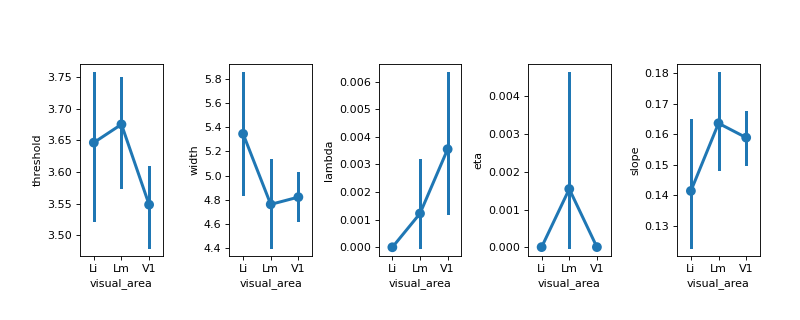

In [34]:
param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']
plot_params = ['threshold', 'width', 'lambda', 'eta','slope']

n_params = len(param_names)

fig, axn = pl.subplots(1, len(plot_params), figsize=(len(plot_params)*2, 4))
for ax, p in zip(axn.flat, plot_params):
    sns.pointplot(x='visual_area', y=p, data=pass_estimates, ax=ax)
    
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.8)

<IPython.core.display.Javascript object>


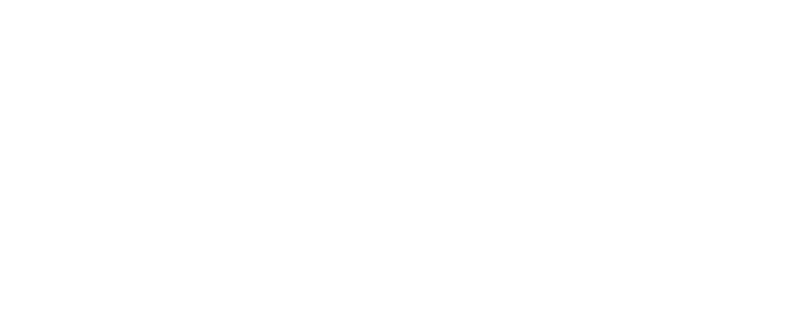

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [716]:
fig, axn = pl.subplots(1,3, figsize=(10,4))
for (va, dk), est in pass_estimates.groupby(['visual_area','datakey']):
    results = R[va][dk]
    curr_fit_cells = est['cell'].unique()
    
    ai = visual_areas.index(va)
    ax=axn[ai]
    for rid, res in results.items():
        if rid not in curr_fit_cells:
            continue
        ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=1, plotAsymptote=False,
                               thresh_height=0.1, npoints=10)
    ax.set_title(va, fontsize=24)
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.5)


<IPython.core.display.Javascript object>


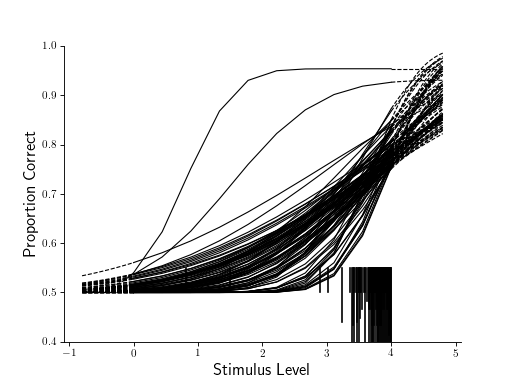

In [717]:
va='Lm'

fig, ax = pl.subplots()
for dk, est in pass_estimates[pass_estimates.visual_area==va].groupby(['datakey']):
    results = R[va][dk]
    curr_fit_cells = est['cell'].unique()
    for rid, res in results.items():
        if rid not in curr_fit_cells:
            continue
        ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=1, plotAsymptote=False,
                               thresh_height=0.55, npoints=10)

<IPython.core.display.Javascript object>


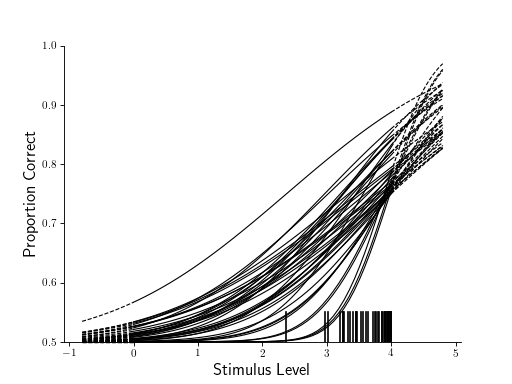

In [712]:
va='Li'

fig, ax = pl.subplots()
for dk, est in pass_estimates[pass_estimates.visual_area==va].groupby(['datakey']):
    results = R[va][dk]
    curr_fit_cells = est['cell'].unique()
    for rid, res in results.items():
        if rid not in curr_fit_cells:
            continue
        ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=1, plotAsymptote=False,
                               thresh_height=0.55, npoints=50)

In [718]:
pass_estimates.head()

,threshold,width,lambda,gamma,eta,slope,thr,cell,visual_area,datakey
1,3.892998,1.914792,1.401999e-08,0.5,1.602869e-07,0.342701,3.892998,261,Li,20190422_JC076_fov1
10,3.908429,3.619414,5.050646e-11,0.5,9.843335e-10,0.181301,3.908429,37,Li,20190602_JC091_fov1
11,3.473057,7.589552,4.058454e-09,0.5,6.106602e-09,0.086461,3.473057,38,Li,20190602_JC091_fov1
12,3.524935,7.561378,1.453119e-08,0.5,3.145398e-10,0.086783,3.524935,39,Li,20190602_JC091_fov1
13,3.904229,5.447926,6.400028e-08,0.5,2.762301e-11,0.120450,3.904230,40,Li,20190602_JC091_fov1


In [10]:
mean_est = pass_estimates.groupby(['visual_area', 'datakey']).mean().reset_index()

<IPython.core.display.Javascript object>


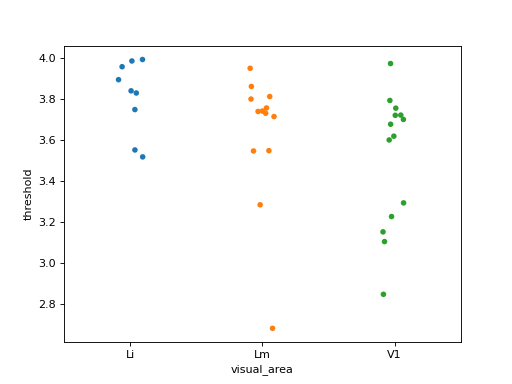

<AxesSubplot:xlabel='visual_area', ylabel='threshold'>

In [11]:
fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y='threshold', data=mean_est, ax=ax)

<IPython.core.display.Javascript object>


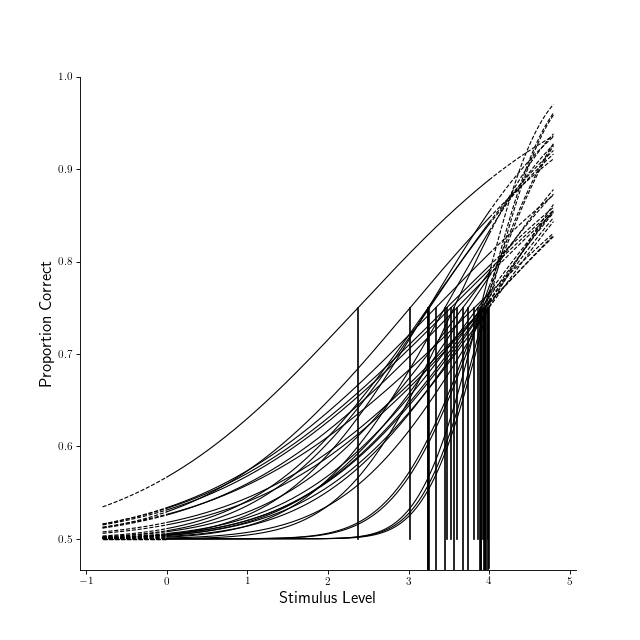

<IPython.core.display.Javascript object>


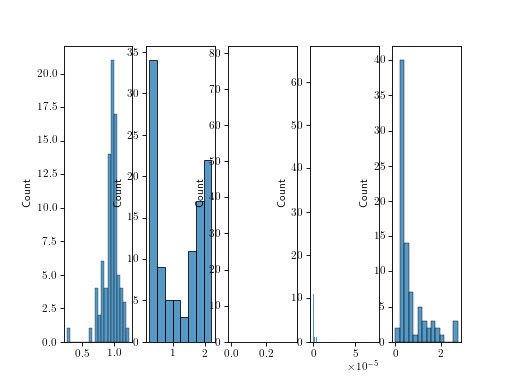

In [371]:
fig, axn = pl.subplots(1, n_params)
for ax, p in zip(axn.flat, ['threshold', 'width', 'lambda', 'eta', 'slope']):
    sns.histplot(data=estimates[p].values, ax=ax)



# Stimuli

In [40]:
morphlevels = SDF['20190616_JC097_fov1']['morphlevel'].unique()
stimdir = '/n/coxfs01/behavior-data/stimuli/D1D2M105_yrot_fine_steps/final'
curr_morphs = [m for m in sorted(morphlevels) if m!=-1]

image_fns = [os.path.join(stimdir, 'morph%i_y0.png' % m) for m in curr_morphs]
images={}
for m, fn in zip(curr_morphs, image_fns):
    images[m] = pl.imread(fn)

In [45]:
morph_lut, a_morphs, b_morphs = get_morph_levels()


In [46]:
morph_steps={}
for k, v in morph_lut.items():
    if v not in morph_steps.keys():
        morph_steps[v] =[]
    morph_steps[v].append(k)
morph_steps

{1: [40, 66], 2: [27, 79], 3: [14, 92], 4: [0, 106], 0: [53], -1: [-1]}

In [47]:
morphsteps = sorted([k for k, v in morph_steps.items() if k>=0])
morphsteps

[0, 1, 2, 3, 4]

<IPython.core.display.Javascript object>


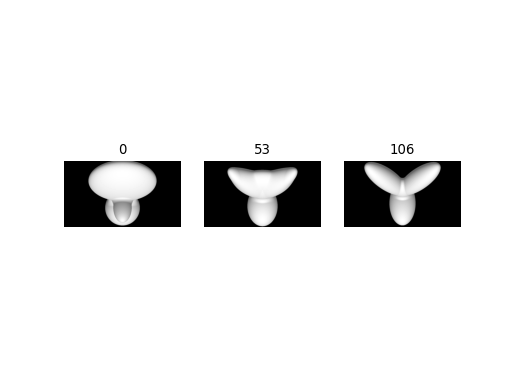

In [48]:
fig, axn = pl.subplots(1,3)
for ax, m in zip(axn.flat, [0, 53, 106]):
    ax.imshow(images[m], cmap='gray')
    ax.set_title(m)
    ax.axis('off')

<IPython.core.display.Javascript object>


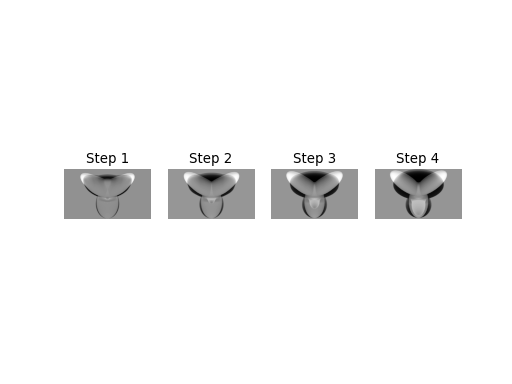

In [51]:
fig, axn = pl.subplots(1, len(morphsteps)-1)
diffs = {}
d=[]
for mstep, mims in morph_steps.items():
    if mstep <=0:
        continue
    ai = mstep-1
    ax = axn[ai]
    im1 = images[mims[0]]
    im2 = images[mims[1]] 
    diff_im = im1 - im2
    ax.imshow(diff_im, cmap='Greys')
    ax.axis('off')
    d.append(np.sum(diff_im))
    
    ediff = sp.spatial.distance.euclidean(im1.ravel(), im2.ravel())
    
    diffs[mstep] = ediff
    ax.set_title("Step %i" % mstep)
diffs.update({0: 0})


<IPython.core.display.Javascript object>


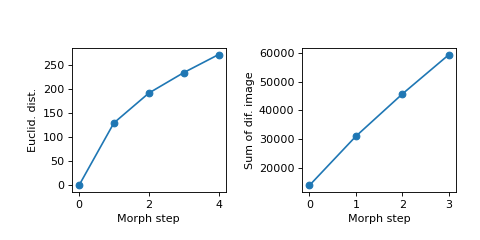

In [56]:
fig, axn = pl.subplots(1,2, figsize=(6,3))
ax=axn[0]
ax.plot(morphsteps, [diffs[v] for v in morphsteps], marker='o')
ax.set_xlabel('Morph step')
ax.set_ylabel('Euclid. dist.')

ax=axn[1]
ax.plot(d, marker='o')
ax.set_xlabel('Morph step')
ax.set_ylabel('Sum of dif. image')

pl.subplots_adjust(left=0.15, right=0.95, bottom=0.2, wspace=0.5, top=0.8)


In [620]:
diffs

{1: 129.56948852539062,
 2: 191.359619140625,
 3: 233.80543518066406,
 4: 271.2908630371094}

In [625]:
np.linalg.norm(im2-im1)

271.29086

<IPython.core.display.Javascript object>


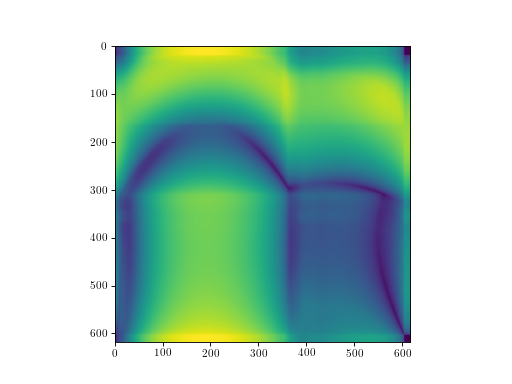

In [630]:
d1 = sp.spatial.distance.cdist(im2, im1, 'euclidean')
pl.figure()
pl.imshow(d1)

In [636]:
np.sum(diff_im)


-59371.383

In [343]:
pd.DataFrame(res['Fit'], index=param_names, columns=[rid]).T


,threshold,width,lambda,gamma,eta
217,0.807907,0.688368,1.084300e-09,0.5,2.040462e-07


In [323]:
rid = 217

auc_r = best_auc[(best_auc['cell']==rid)].copy()
data = data_matrix_from_auc(auc_r)
data

array([[ 0.        , 14.        , 30.        ],
       [ 0.13207547, 17.        , 30.        ],
       [ 0.25471698, 18.        , 30.        ],
       [ 0.37735849, 15.        , 30.        ],
       [ 0.5       , 18.        , 30.        ],
       [ 0.62264151, 17.        , 30.        ],
       [ 0.74528302, 21.        , 30.        ],
       [ 0.86792453, 23.        , 30.        ],
       [ 1.        , 28.        , 30.        ]])

In [353]:
ps.getThreshold(res, 0.75)[0] # Value at which function reaches at_pc correct
ps.getSlope(res, ps.getThreshold(res, 0.75)[0]) # Slope at given stimulus level

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


0.807906798155016

In [357]:
ps.getSlope(res, ps.getThreshold(res, 0.75)[0])

0.9532720278663362

In [324]:
opts = dict()
opts['sigmoidname'] = 'weibull'
opts['expType'] = '2AFC' #'2AFC'
opts['threshPC'] = 0.5
#opts['stepN']= [25,20,10,20]  #[40,40,50,20,20]
#  [threshold, width, upper asymptote, lower asymptote, variance scaling] 
# opts['borders'] = bounds
# opts['moveBorders'] = False
# opts['priors'] = priors
res = ps.psignifit(data, opts)


(array([], dtype=int64),)


/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [21]:
param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']
n_params = len(param_names)
#first lets have a look at the results with the standard prior strength:
# print('Fit:', res['Fit'].round(2))


<IPython.core.display.Javascript object>


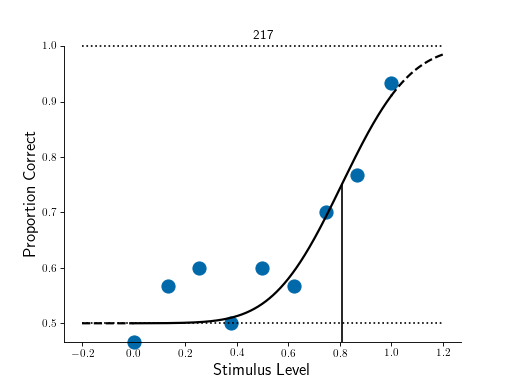

Text(0.5, 1.0, '217')

In [326]:
fig, ax = pl.subplots()
ax = ps.psigniplot.plotPsych(res, axisHandle=ax)
ax.set_title(rid)

# figname = 'psychometric_%s' % animalid
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

In [333]:
ps.getThreshold(res, 0.75)


(0.807906798155016,
 array([[0.57525885, 1.44231971],
        [0.6195629 , 1.24934457],
        [0.69767686, 1.00144201]]))

In [335]:
ps.getThreshold(res, 0.75, 1)

(0.9490430475764219,
 array([[0.63759465, 1.35223187],
        [0.69325121, 1.27614412],
        [0.80064194, 1.13613742]]))

In [334]:
ps.getSlope(res, 0.75)


0.9174598161274641

In [247]:
res['options']['sigmoidHandle']

<function psignifit.getSigmoidHandle.getSigmoidHandle.<locals>.<lambda>(X, m, width)>

<IPython.core.display.Javascript object>


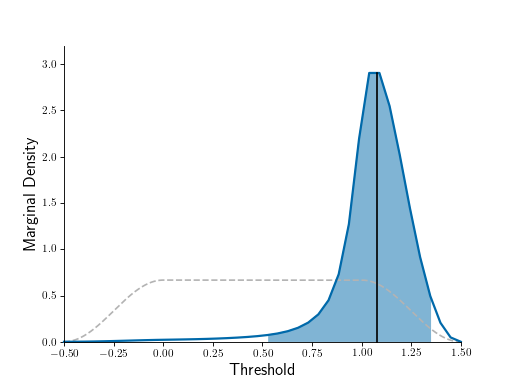

In [248]:
param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']
n_params = len(param_names)

pi = 0
par = param_names[pi]
fig, ax = pl.subplots()

ax=ps.psigniplot.plotMarginal(res, dim=pi, axisHandle=ax)


<IPython.core.display.Javascript object>


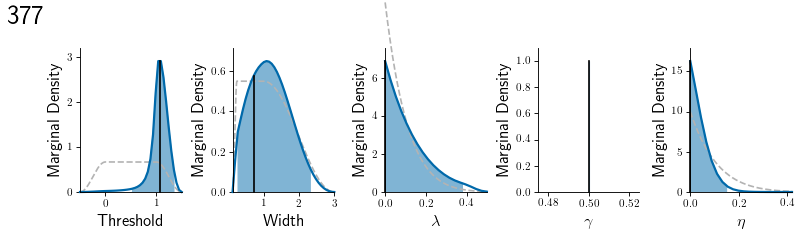

Error: The parameter you wanted to plot was fixed in the analysis!


/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:318: UserWarning: Attempting to set identical left == right == 0.5 results in singular transformations; automatically expanding.
  plt.xlim([min(x), max(x)])


Text(0.01, 0.9, '377')

In [249]:
param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']
n_params = len(param_names)
fig, axn = pl.subplots(1, n_params, figsize=(10,3))

for pi, par in enumerate(param_names):
    ax=axn[pi]
    ax=ps.psigniplot.plotMarginal(res, dim=pi, axisHandle=ax)
pl.subplots_adjust(left=0.1, right=0.99, bottom=0.2, wspace=0.5, top=0.8)

fig.text(0.01, 0.9, rid, fontsize=24)

# figname = 'marginals_%s' % animalid
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


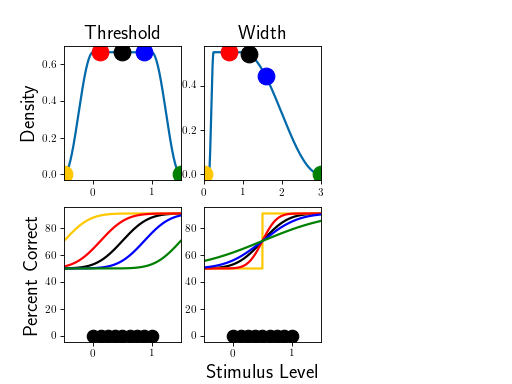

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:443: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,3,4)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:445: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,3,1)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:443: Ma

In [250]:
fig, ax = pl.subplots()
ps.psigniplot.plotPrior(res) #,axisHandle=ax)

# Goodness of fit

In [276]:
def getDeviance(result,Nsamples=None):
    fit = result['Fit']
    data = result['data']
    pPred = fit[3] + (1-fit[2]-fit[3]) * result['options']['sigmoidHandle'](data[:,0], fit[0], fit[1])
    
    pMeasured = data[:,1]/data[:,2]
    loglikelihoodPred = data[:,1]*np.log(pPred)+(data[:,2]-data[:,1])*np.log((1-pPred))
    loglikelihoodMeasured = data[:,1]*np.log(pMeasured)+(data[:,2]-data[:,1])*np.log((1-pMeasured))
    loglikelihoodMeasured[pMeasured==1] = 0;
    loglikelihoodMeasured[pMeasured==0] = 0;

    #devianceResiduals = -2*np.sign(pMeasured-pPred)*(loglikelihoodMeasured - loglikelihoodPred)
    #deviance = np.sum(np.abs(devianceResiduals))
    devianceResiduals = np.sign(pMeasured-pPred)*np.sqrt(2*(loglikelihoodMeasured - loglikelihoodPred))
    deviance = np.sum(devianceResiduals**2)
    
    if Nsamples is None:
        return devianceResiduals,deviance
    else: 
        r_vals=[]
        samples_devianceResiduals = np.zeros((Nsamples,data.shape[0]))
        for iData in range(data.shape[0]):
            samp_dat = np.random.binomial(data[iData,2],pPred[iData],Nsamples)
            #print(samp_dat)
            pMeasured = samp_dat/data[iData,2]
            #print(pMeasured)
            loglikelihoodPred = samp_dat*np.log(pPred[iData])+(data[iData,2]-samp_dat)*np.log(1-pPred[iData])
            loglikelihoodMeasured = samp_dat*np.log(pMeasured)+(data[iData,2]-samp_dat)*np.log(1-pMeasured)
            loglikelihoodMeasured[pMeasured==1] = 0
            loglikelihoodMeasured[pMeasured==0] = 0
            #samples_devianceResiduals[:,iData] = -2*np.sign(pMeasured-pPred[iData])*(loglikelihoodMeasured - loglikelihoodPred)
            samples_devianceResiduals[:,iData] = np.sign(pMeasured-pPred[iData])*np.sqrt(2.*(loglikelihoodMeasured - loglikelihoodPred))
        r_vals=[]
        for iS in range(Nsamples):
            sr = samples_devianceResiduals[iS, :]
            r, p = spstats.pearsonr(pPred, sr)
            r_vals.append(r)
            
        #samples_deviance = np.sum(np.abs(samples_devianceResiduals),axis=1)
        samples_deviance = np.sum(samples_devianceResiduals**2,axis=1)
        return devianceResiduals,deviance,samples_devianceResiduals,samples_deviance, r_vals

def get_empirical_ci(stat, ci=0.95):
    p = ((1.0-ci)/2.0) * 100
    lower = np.percentile(stat, p) #max(0.0, np.percentile(stat, p))
    p = (ci+((1.0-ci)/2.0)) * 100
    upper = np.percentile(stat, p) # min(1.0, np.percentile(x0, p))
    #print('%.1f confidence interval %.2f and %.2f' % (alpha*100, lower, upper))
    return lower, upper

In [277]:
d_resid, d, samples_d_resid, samples_d, r_vals = getDeviance(res, Nsamples=5000)
d_resid.shape, d.shape, samples_d_resid.shape, samples_d.shape
assert d == np.sum(d_resid**2)
print(d)

2.9196756869971026


In [278]:
fit = res['Fit']
data = res['data']
pPred = fit[3] + (1-fit[2]-fit[3]) * res['options']['sigmoidHandle'](data[:,0], fit[0], fit[1])
data_r, data_p = spstats.pearsonr(pPred, d_resid)
ci_lo, ci_hi = get_empirical_ci(r_vals)

<IPython.core.display.Javascript object>


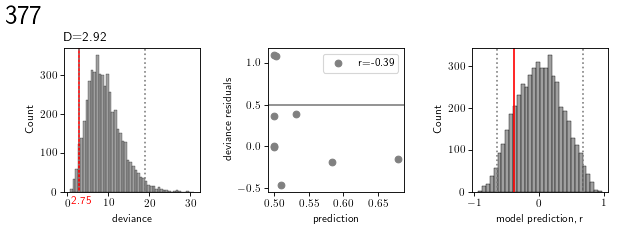

Text(0.01, 0.9, '377')

In [279]:
col='gray'
fig,axn=pl.subplots(1,3, figsize=(8,3))
ax=axn[0]
sns.histplot(data=samples_d, ax=ax, color=col)
ax.axvline(x=d, color='r')
ax.set_xlabel('deviance')
ci_lo_sampled, ci_hi_sampled = get_empirical_ci(samples_d)
for ci in [ci_lo_sampled, ci_hi_sampled]:
    ax.axvline(x=ci, color=col, linestyle=':')
ax.text(ci_lo_sampled-2, -30, round(ci_lo_sampled, 2), color='r')
ax.set_title('D=%.2f' % d, loc='left')

ax=axn[1]
ax.scatter(pPred, d_resid, label='r=%.2f' % data_r, c=col)
ax.legend()
ax.set_xlabel('prediction')
ax.set_ylabel('deviance residuals')
ax.axhline(y=0.5, color='gray')

ax=axn[2]
sns.histplot(data=r_vals, ax=ax, color=col)
ax.axvline(x=data_r, color='r')
for ci in [ci_lo, ci_hi]:
    ax.axvline(x=ci, color=col, linestyle=':')
ax.set_xlabel('model prediction, r')

pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, wspace=0.5, top=0.8)

fig.text(0.01, 0.9, rid, fontsize=24)

# figname = 'deviance_%s' % animalid
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)


In [283]:
min(r_vals)

-0.9417343157475857